In [ ]:
"""
Deterministic Meta Model
UNFINISHED CODE
"""
import scipy.integrate as spi
import numpy as np
import matplotlib.pylab as plt


class Meta:
    def __init__(self, n, c):
        # define parameters
        self.n_pop = n
        self.beta = 1.0*np.ones(n)
        self.gamma = 0.1*np.ones(n)
        self.nu = 0.0001*np.ones(n)
        self.mu = 0.0001*np.ones(n)
        self.m = c*np.ones((n,n)) 
        self.mig_rate = self.m - np.diag(np.diag(self.m))

        # determine initial conditions
        self.X0 = 0.1*np.ones(n)
        self.Y0=0.0*np.ones(n)
        self.Y0[0]=0.0001

        # define time range
        n_days = 7 * 365
        self.t_range = np.arange(0, n_days, 1)
    
    
    def diff_eqs(self, inp, t):
        """
        Main set of equations in the SIR model with metapopulations. 
        """
        n = self.n_pop
        Y = np.zeros((2*n))
        V = inp

        # iterate over amount of subpopulations
        for i in range(n):
            Y[i] = self.nu[i] - self.beta[i]*V[i]*V[n+i] - self.mu[i]*V[i]; 
            Y[n+i] = self.beta[i]*V[i]*V[n+i] - self.mu[i]*V[n+i] - self.gamma[i]*V[n+i]

            for j in range(n):
                Y[i] += self.mig_rate[i][j]*V[j] - self.mig_rate[j][i]*V[i];
                Y[n+i] += self.mig_rate[i][j]*V[n+j] - self.mig_rate[j][i]*V[n+i];
        return Y

# create Meta object with 2 subpopulations
values = [0.0, 0.0001, 0.1]
for value in values:
    meta = Meta(2,value)
    solution = spi.odeint(meta.diff_eqs, np.hstack((meta.X0,coupling.Y0)), meta.t_range)

    # plot results
    n = coupling.n_pop
    plt.plot(no_coupling.t_range/365.0, solution[:,0], color='blue')
    plt.plot(no_coupling.t_range/365.0, solution[:,1], color='red')
    plt.xlabel('Time (Years)')
    plt.ylabel('Susceptibles')
plt.show()

#     plt.plot(no_coupling.t_range/365.0, solution[:,0+n], color='blue')
#     plt.plot(no_coupling.t_range/365.0, solution[:,1+n], color='red')
#     plt.ylabel('Infected')
#     plt.xlabel('Time (Years)')
#     plt.show()

In [ ]:
"""
Stochastic Meta Model
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import random
import pandas as pd

class Gillespie:

    def __init__(self, X, Y, beta, gamma, mu, coupling):
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.delta = 0.01
        self.epsilon = 0.001
        self.N = 100
        self.X = X
        self.Y = Y
        self.Z = 0
        self.T = 0
        self.coupling = coupling
        self.moved = None


    def get_rates(self, X, Y, Z):
        """
        Determine at which rate an event occurs.
        """
        # Birth
        rate_E1 = self.mu * self.N
        
        # Transmission
        rate_E2 = self.beta * self.X * self.Y / self.N
        
        # Recovery
        rate_E3 = self.gamma * self.Y
        
        # Death
        rate_E4 = self.mu * self.X
        rate_E5 = self.mu * self.Y
        rate_E6 = self.mu * self.Z
        
        # Movement
        rate_E7 = self.coupling * self.X
        rate_E8 = self.coupling * self.Y
        rate_E9 = self.coupling * self.Z


        events = [rate_E1, rate_E2, rate_E3, rate_E4, rate_E5, rate_E6, rate_E7, rate_E8, rate_E9]

        return events

    def gillespie(self, other, time):
        """
        Choose the next time and event.
        """

        events = self.get_rates(self.X, self.Y, self.Z)

        Rtotal = sum(events)

        # Get reaction time for both subpopulations
        if time:
            random_time = np.random.rand()
            tau = (1.0/Rtotal) * np.log((1.0/random_time))
            self.T += tau
            other.T += tau

        # Determine which event occurs
        # Make list of reaction intervals
        rates = []
        for i in events:
            rates.append(i/Rtotal)

        random_event = random.uniform(0, max(rates))

        # Find event to be executed based on closest number to
        # a random number in rates-array
        found = self.find_nearest(rates, random_event)

        # Retrieve which event is related to this interval
        for k in range(len(rates)):
            if rates[k] == found:
                index = k
                break

        # Birth
        if index == 0:
            self.X += 1

        # Transmission
        elif index == 1:
            self.Y += 1
            self.X -= 1

        # Recovery
        elif index == 2:
            self.Z += 1
            self.Y -= 1

        # Death
        elif index == 3:
            self.X -= 1
        elif index == 4:
            self.Y -= 1
        elif index == 5:
            self.Z -= 1
        
        # Movement
        elif index == 6:
            self.X -=1
            other.X += 1
            self.moved = 'X'
        elif index == 7:
            self.Y -= 1
            other.Y += 1
            self.moved = 'Y'
        else:
            self.Z -= 1
            other.Z += 1
            self.moved = 'Z'
        
        return self.X, self.Y, self.Z, self.T

    def find_nearest(self, array, value):
        """
        Find nearest value in array.
        """

        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]


if __name__ == '__main__':
    
    # determine different coupling rates
    coupling_rates = [0.1, 0.3, 0.9]
    
    # for each rate, run the model with 1000 iterations
    for rate in coupling_rates:
        pop_1 = Gillespie(99, 1, 1/3, 0.01, 0.003, rate)
        pop_2 = Gillespie(100, 0, 1/3, 0.01, 0.003, rate)

        # keep track of results of each iteration
        results_1 = []
        results_2 = []
        time = []

        # iterations
        for i in range(1000):
            X,Y,Z,T = pop_1.gillespie(pop_2, True)
            #print("status pop_1 = ", pop_1.moved)
            results_1.append([X,Y,Z])
            X,Y,Z,T = pop_2.gillespie(pop_1, False)
            #print("status pop_2 = ", pop_2.moved)
            #print("")
            results_2.append([X,Y,Z])
            time.append(T)


            # get moved people back to their original population
            if pop_1.moved != None:
                #print("someone moved from pop_1")
                state = pop_1.moved
                if state == 'X':
                    pop_1.X += 1
                    pop_2.X -= 1
                elif state == 'Y':
                    pop_1.Y += 1
                    pop_2.Y -= 1
                else:
                    pop_1.Z += 1
                    pop_2.Z -= 1
                pop_1.moved = None

            if pop_2.moved != None:
                #print("someone moved from pop_2")
                state = pop_2.moved
                if state == 'X':
                    pop_2.X += 1
                    pop_1.X -= 1
                elif state == 'Y':
                    pop_2.Y += 1
                    pop_1.Y -= 1
                else:
                    pop_2.Z += 1
                    pop_1.Z -= 1
                pop_2.moved = None

        plots_1 = []
        plots_2 = []
        for result in results_1:
            plots_1.append(result)
        for result in results_2:
            plots_2.append(result)

        plt.plot(time, plots_1)
        plt.legend(['Susceptibles', 'Infecteds', 'Recovereds'], loc="upper right")
        plt.xlabel("Time")
        plt.ylabel("Individuals")
        plt.show()

        plt.plot(time, plots_2)
        plt.legend(['Susceptibles', 'Infecteds', 'Recovereds'], loc="upper right")
        plt.xlabel("Time")
        plt.ylabel("Individuals")
        plt.show()
        
        plt.plot(coupling

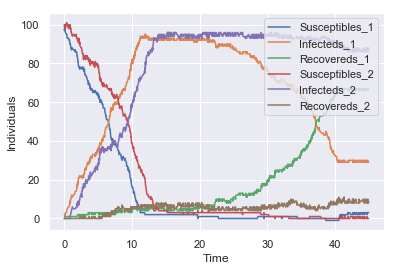

max pop_1 =  39.207811733745345
max pop_2 =  44.95734628491199


In [4]:
"""
Stochastic Meta Model
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import random
import pandas as pd
import itertools

class Gillespie:

    def __init__(self, X, Y, beta, gamma, mu, coupling):
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.delta = 0.01
        self.epsilon = 0.001
        self.N = 100
        self.X = X
        self.Y = Y
        self.Z = 0
        self.T = 0
        self.coupling = coupling
        self.moved = None
        self.max = self.Y


    def get_rates(self, X, Y, Z):
        """
        Determine at which rate an event occurs.
        """
        # Birth
        rate_E1 = self.mu * self.N
        
        # Transmission
        rate_E2 = self.beta * self.X * self.Y / self.N
        
        # Recovery
        rate_E3 = self.gamma * self.Y
        
        # Death
        rate_E4 = self.mu * self.X
        rate_E5 = self.mu * self.Y
        rate_E6 = self.mu * self.Z
        
        # Movement
        rate_E7 = self.coupling * self.X
        rate_E8 = self.coupling * self.Y
        rate_E9 = self.coupling * self.Z


        events = [rate_E1, rate_E2, rate_E3, rate_E4, rate_E5, rate_E6, rate_E7, rate_E8, rate_E9]

        return events

    def gillespie(self, other, time):
        """
        Choose the next time and event.
        """

        events = self.get_rates(self.X, self.Y, self.Z)

        Rtotal = sum(events)

        # Get reaction time for both subpopulations
        if time:
            random_time = np.random.rand()
            tau = (1.0/Rtotal) * np.log((1.0/random_time))
            self.T += tau
            other.T += tau

        # Determine which event occurs
        # Make list of reaction intervals
        rates = []
        for i in events:
            rates.append(i/Rtotal)

        random_event = random.uniform(0, max(rates))

        # Find event to be executed based on closest number to
        # a random number in rates-array
        found = self.find_nearest(rates, random_event)

        # Retrieve which event is related to this interval
        for k in range(len(rates)):
            if rates[k] == found:
                index = k
                break

        # Birth
        if index == 0:
            self.X += 1

        # Transmission
        elif index == 1:
            self.Y += 1
            self.X -= 1

        # Recovery
        elif index == 2:
            self.Z += 1
            self.Y -= 1

        # Death
        elif index == 3:
            self.X -= 1
        elif index == 4:
            self.Y -= 1
        elif index == 5:
            self.Z -= 1
        
        # Movement
        elif index == 6:
            self.X -=1
            other.X += 1
            self.moved = 'X'
        elif index == 7:
            self.Y -= 1
            other.Y += 1
            self.moved = 'Y'
        else:
            self.Z -= 1
            other.Z += 1
            self.moved = 'Z'
        
        if self.Y > self.max:
            self.max = self.T
        
        return self.X, self.Y, self.Z, self.T

    def find_nearest(self, array, value):
        """
        Find nearest value in array.
        """

        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]


if __name__ == '__main__':
    
    # determine different coupling rates
    coupling_rates = [0.2]
    peak_1 = []
    peak_2 = []
    lag = []
    # for each rate, run the model with 1000 iterations
    for rate in coupling_rates:
        pop_1 = Gillespie(99, 1, 1/3, 0.01, 0.003, rate)
        pop_2 = Gillespie(100, 0, 1/3, 0.01, 0.003, rate)

        # keep track of results of each iteration
        results_1 = []
        results_2 = []
        time = []

        # iterations
        for i in range(1000):
            X,Y,Z,T = pop_1.gillespie(pop_2, True)
            #print("status pop_1 = ", pop_1.moved)
            results_1.append([X,Y,Z])
            X,Y,Z,T = pop_2.gillespie(pop_1, False)
            #print("status pop_2 = ", pop_2.moved)
            #print("")
            results_2.append([X,Y,Z])
            time.append(T)


            # get moved people back to their original population
            if pop_1.moved != None:
                state = pop_1.moved
                if state == 'X':
                    pop_1.X += 1
                    pop_2.X -= 1
                elif state == 'Y':
                    pop_1.Y += 1
                    pop_2.Y -= 1
                else:
                    pop_1.Z += 1
                    pop_2.Z -= 1
                pop_1.moved = None

            if pop_2.moved != None:
                state = pop_2.moved
                if state == 'X':
                    pop_2.X += 1
                    pop_1.X -= 1
                elif state == 'Y':
                    pop_2.Y += 1
                    pop_1.Y -= 1
                else:
                    pop_2.Z += 1
                    pop_1.Z -= 1
                pop_2.moved = None

        plots_1 = []
        plots_2 = []
        for result in results_1:
            plots_1.append(result)
        for result in results_2:
            plots_2.append(result)

        colors = itertools.cycle(['r', 'b', 'g', 'y', 'm', 'k'])
        plt.plot(time, plots_1)
        plt.plot(time, plots_2)
        plt.legend(['Susceptibles_1', 'Infecteds_1', 'Recovereds_1', 'Susceptibles_2', 'Infecteds_2', 'Recovereds_2'], loc="upper right")
        plt.xlabel("Time")
        plt.ylabel("Individuals")
        #plt.set_color_cycle(['r', 'b', 'y', 'k', 'm', 'g'])
        plt.show()
        
        print("max pop_1 = ", pop_1.max)
        print("max pop_2 = ", pop_2.max)

#         plt.plot(time, plots_2)
#         plt.legend(['Susceptibles', 'Infecteds', 'Recovereds'], loc="upper right")
#         plt.xlabel("Time")
#         plt.ylabel("Individuals")
#         plt.show()
        
#         peak_1.append(pop_1.max)
#         peak_2.append(pop_2.max)
#         difference = pop_2.max - pop_1.max
#         lag.append(difference)

    # plot lag between peaks of population 1 and 2, with coupling on the x-axis and the lag on y-axis 
#     plt.plot(coupling_rates, peak_1, linestyle='dashed')
#     plt.plot(coupling_rates, peak_2)
#     plt.legend(['population 1', 'population 2'], loc="upper right")
#     plt.xlabel("Coupling Pij")
#     plt.ylabel("Moment in time of peak (Lag)")
#     plt.show()
    
#     plt.plot(coupling_rates, lag)
#     plt.xlabel("Coupling Pij")
#     plt.ylabel("Lag")
#     plt.show()

    # TODO: plot coupling (X axis) to the probability of triggering an epidemic in population 2 
    # But in the book they have a deterministic model for population one, so the plot they showcase on the right of figure 
    # 7.1 might not be a good fit for our metapopulation model which has stochastic 
